## This notebook is going to be a cleaner version of the satellite finding for the full PDR region

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
#matplotlib.matplotlib_fname()
#import linetools.utils as ltu
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
import copy
from colossus.halo import profile_nfw
%config InlineBackend.figure_format = 'retina'

In [2]:
# read in the data
data_pth = '/Users/astro/Desktop/GitHub/satellite_fraction/data/'
data_file = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'

hdu1 = fits.open(data_file)
data_table = Table(hdu1[1].data)

In [3]:
# set cosmology params
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so

In [4]:
pdr_use = Table(names = data_table.colnames)

for i in range(len(np.array(data_table['logm_max']))):
    if data_table['z_best'][i] > .25 and data_table['z_best'][i] < .45:
        pdr_use.add_row(data_table[i])

In [5]:
# Now to find r_halo
r_halo = mass_so.M_to_R((10**pdr_use['logmh_vir'])*h , pdr_use['z_best'], 'vir')/h # kpc

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(pdr_use['z_best'])
r_halo_deg = ((r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

In [6]:
# put the array data into a new table
pdr_use['r_halo'] = r_halo_deg
pdr_use.sort('logm_max')

# bins before reversing table
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]
pdr_use.reverse() # rank order by mass

In [7]:
# actual satellite finding
import satellite_finder as sf
mass_center_004, frac_sat_004, err_004 = sf.run_pdr_satellite(pdr_use, .004, mass_bins)
mass_center_0015, frac_sat_0015, err_0015 = sf.run_pdr_satellite(pdr_use, .0015, mass_bins)

/Users/astro/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


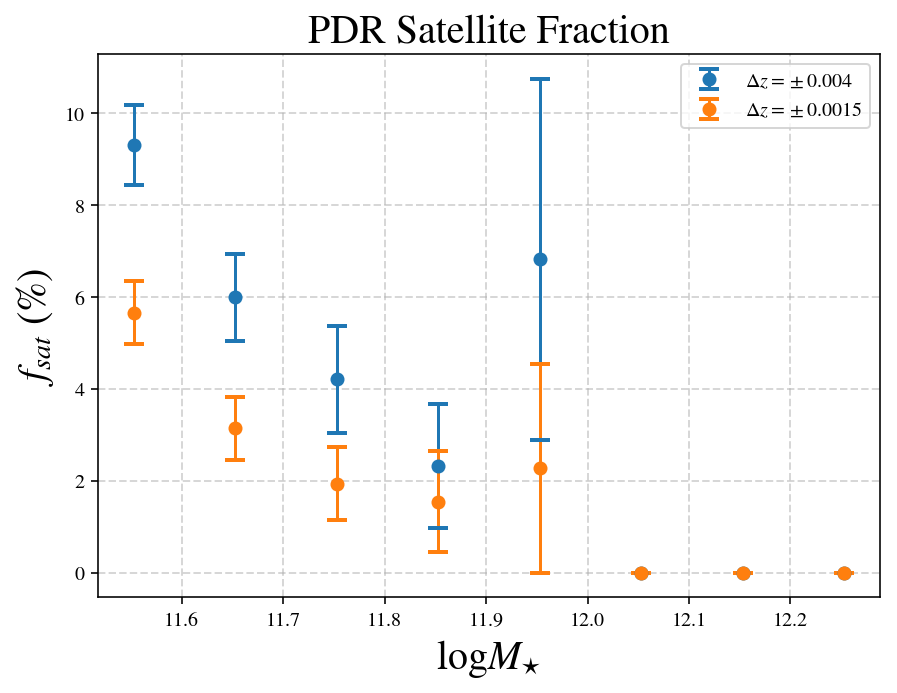

In [10]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center_004, frac_sat_004, err_004, fmt='o',capthick=2, capsize=5, label = '$\Delta z = \pm 0.004$')
ax1.errorbar(mass_center_0015, frac_sat_0015, err_0015, fmt='o',capthick=2, capsize=5, label = '$\Delta z = \pm 0.0015$')
#ax1.errorbar(mass_center_008, frac_sat_008, err_008, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.008$')
#ax1.errorbar(mass_center_02, frac_sat_02, err_02, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.02$')
#ax1.errorbar(mass_center_04, frac_sat_04, err_04, fmt='o',capthick=2, capsize=5, label = '$\Delta z = \pm 0.05$')
#ax1.errorbar(mass_center_041, frac_sat_041, err_041, fmt='o',capthick=2, capsize=5, label = '$dz = \pm 0.041$')


ax1.set_xlabel(r'$ \log M_{\star}$', fontsize=20)
ax1.set_ylabel(r'$ f_{sat}$ ($\%$)', fontsize=20)
ax1.set_title('PDR Satellite Fraction', fontsize = 20)
ax1.legend()
#plt.savefig('pdr_satellite_fraction.png', dpi = 1000)

### Now I will look at the PDR and Model Satellite Fraction side-by-side

In [24]:
model = data_pth + 'um_ins_exs_logms_10.8_asap_180813.fits'
hdu1 = fits.open(model)
full_table = Table(hdu1[1].data)

for i in range(len(np.array(full_table['logms_max']))):
    if full_table['logms_max'][i] > 11.50:
        model_table.add_row(full_table[i])

centrals_true = []
sats_true = []

for i in range(len(model_table['logms_max'])):
    if model_table['upid'][i] == -1:
        centrals_true.append(model_table['logms_max'][i])
    else:
        sats_true.append(model_table['logms_max'][i])
        
        
# range of masses
mmin = np.min(model_table['logms_max'])
mmax = np.max(model_table['logms_max'])


# from Song's satellite finding code
mass_bins = [11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 12.1, 12.2, 12.3]

hist_all, edges_all = np.histogram(model_table['logms_max'], bins=mass_bins)
hist_cen, edges_cen = np.histogram(centrals_true, bins=mass_bins)
hist_sat, edges_sat = np.histogram(sats_true, bins=mass_bins)

mass_center_true = np.log10((10**edges_all[1:] + 10**edges_all[:-1]) / 2)

f_sat_true = (hist_sat / hist_all) * 100

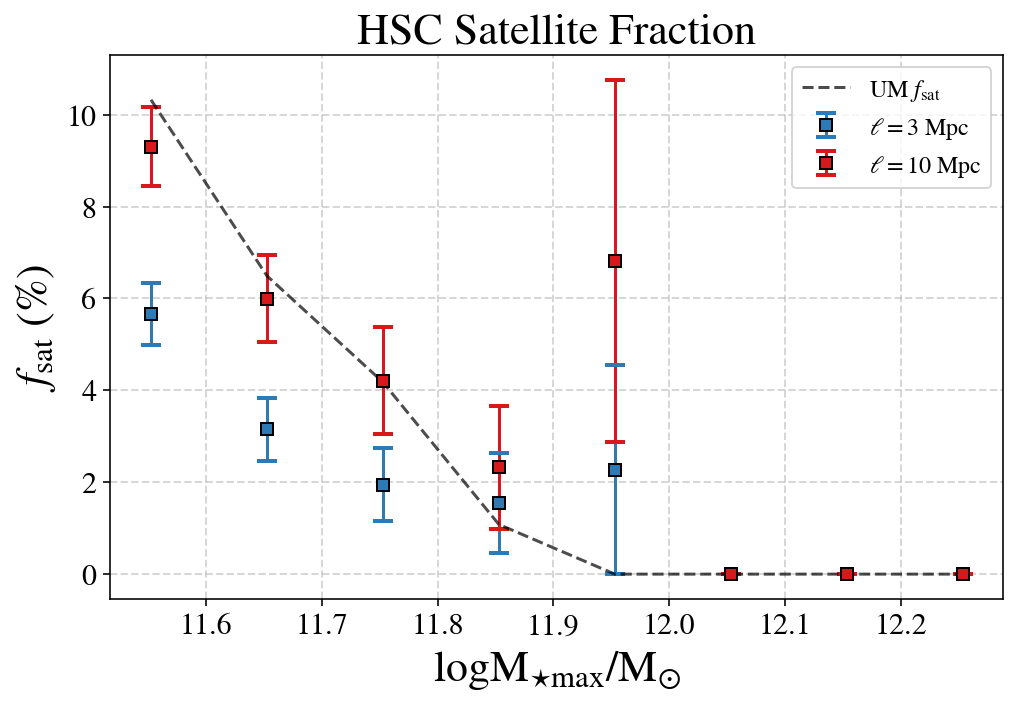

In [32]:
fig = plt.figure(figsize=(8,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center_0015, frac_sat_0015, err_0015, color = '#2c7bb6',fmt='s',mec = 'k',capthick=2, capsize=5, label = '$\ell = 3$ Mpc')
ax1.errorbar(mass_center_004, frac_sat_004, err_004, color = '#d7191c',fmt='s',mec = 'k',capthick=2, capsize=5, label = '$\ell =  10$ Mpc')

ax1.plot(mass_center_true, f_sat_true, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{\mathrm{sat}}$')

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)



ax1.set_xlabel(r'$ \log \mathrm{M_{\star max} / M_{\odot}}$', fontsize=22)
ax1.set_ylabel(r'$f_{\mathrm{sat}}$ (%)', fontsize=22)
ax1.set_title('HSC Satellite Fraction', fontsize = 22)
ax1.legend(fontsize = 12)
plt.savefig('pdr_satellite_fraction.png', dpi = 1000)

* For reference, I want to shade the space between the curves as a region where the fsat curves can exist.

In [12]:
Mean_logM =  [11.454280124360066, 11.578713361036991, 11.701840449447248, 11.827196417870741, 11.951702092177047]
frac_sat =  np.array([13.49764457 , 9.16328442 , 5.41699143 , 1.63398693 , 0.33557047])
frac_sat_low =  np.array([12.57567781 , 8.42428901 , 4.48395825 , 0.87241003 , 0.])
frac_sat_high =  np.array([15.32788663, 10.66708132 , 6.38379205 , 3.04518664 , 1.08401084])

err_high = frac_sat_high - frac_sat
err_low = frac_sat - frac_sat_low

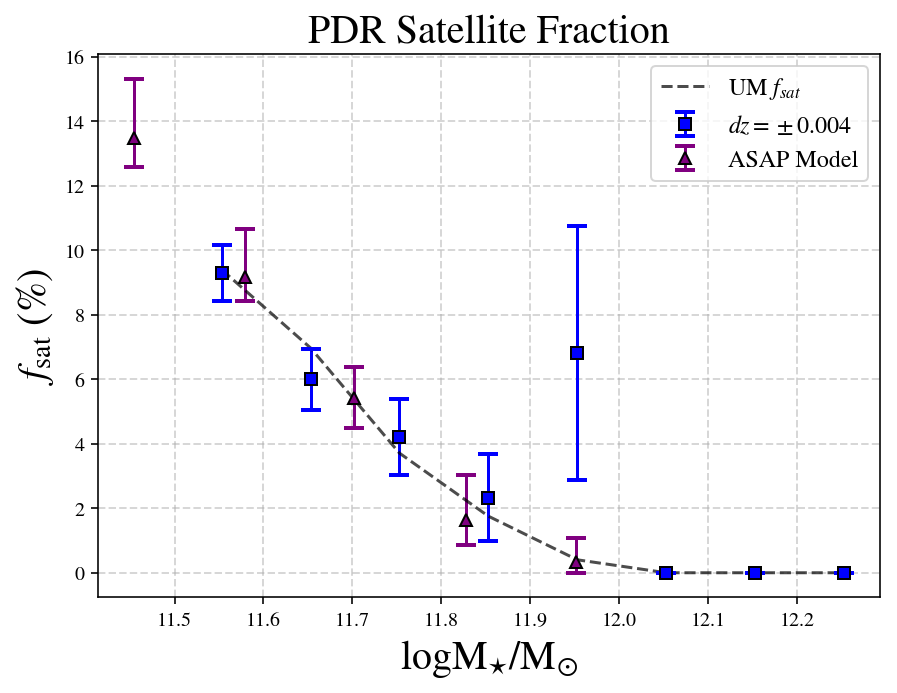

In [41]:
fig = plt.figure(figsize=(7,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.plot(mass_center_mod, frac_sat_mod, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{sat}$')
ax1.errorbar(mass_center_004, frac_sat_004, err_004, color = 'blue',mec = 'k', fmt='s',capthick=2, capsize=5, label = '$dz = \pm 0.004$')
#ax1.errorbar(mass_center_04, frac_sat_04, err_04, color = 'firebrick',mec = 'k',fmt='s',capthick=2, capsize=5, label = '$\ell = \pm 140$ Mpc')
#ax1.fill_between(mass_center_004[0:4], frac_sat_004[0:4], frac_sat_04[0:4], color = 'gray')

ax1.errorbar(Mean_logM, frac_sat, (err_low, err_high), color = 'purple', mec = 'k', fmt='^',capthick=2, capsize=5, label = 'ASAP Model')


ax1.set_xlabel(r'$ \log \mathrm{ M_{\star} / M_{\odot} }$', fontsize=20)
ax1.set_ylabel(r'$ f_{\mathrm{sat}}$ (%)', fontsize=20)
ax1.set_title('PDR Satellite Fraction', fontsize = 20)
ax1.legend(fontsize = 12)

plt.savefig('pdr_ASAP_satellite_fraction.eps', dpi = 1000)

# Bootstrapping

The next order of business is to use some more formal error bars. The way I will do this for now is by resampling and running numerous trials. Later, we may look at uncertainty in M$_{\star \rm tot}$

In [79]:
# start by identifying basic parameters
sample_size = len(pdr_use) # number of galaxies
iterations = range(5)

In [80]:
fsat_trials = []
# now actually bootstrapping

for i in iterations:
    trial_sample = Table(names = pdr_use.colnames) # Table for each trial
    trial_indices = np.random.randint(0, sample_size, size = sample_size) # select random indices
    
    for j in range(len(trial_indices)):
        trial_sample.add_row(pdr_use[trial_indices[j]]) # resampling
        
    trial_sample.sort('logm_max')    
    trial_sample.reverse()
    
    #for k in range(len(trial_sample)):
        # scatter on stellar mass
        # model it as a gaussian centered at galaxy mass and sigma = 0.08dex
        #trial_sample['logm_max'][k] = np.random.normal(trial_sample['logm_max'][k], 0.08)
    
    # now sort and run satellite finder
    
    fsat_trials.append(sf.run_pdr_satellite(trial_sample, 0.004, mass_bins)[1])
    print('trial', i, 'done')
# need to find the standard deviation of the results
np.std(fsat_trials, axis = 0)

trial 0 done
trial 1 done
trial 2 done
trial 3 done
trial 4 done


array([0.2706548 , 0.94395518, 1.32309572, 1.07952855, 3.19658301,
       0.        , 0.        , 0.        ])

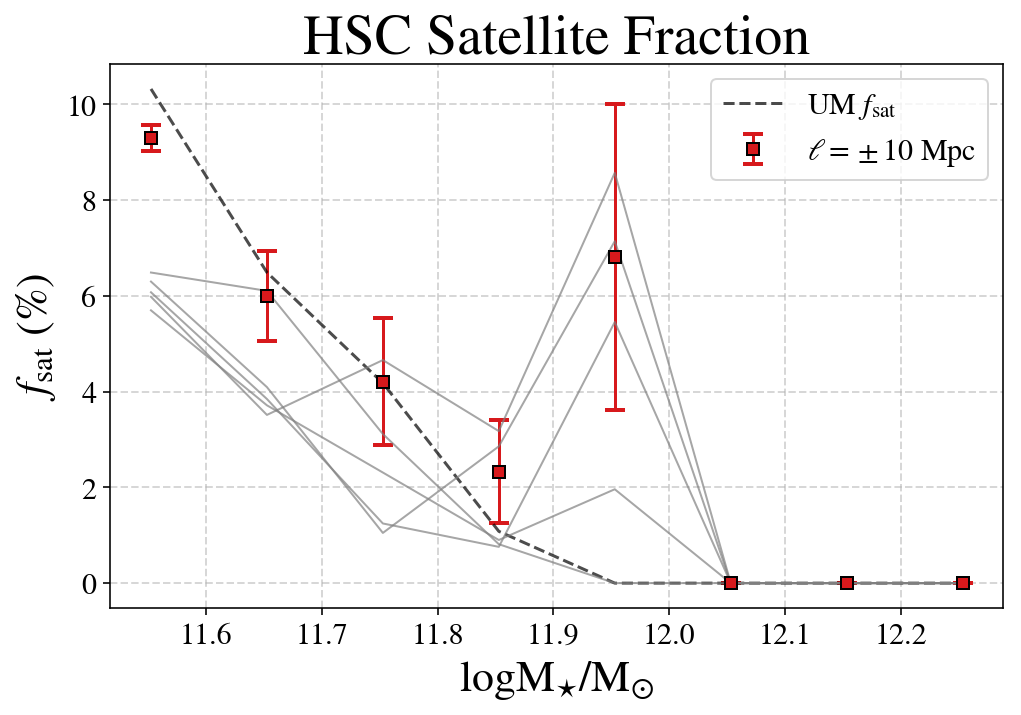

In [81]:
fig = plt.figure(figsize=(8,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)


ax1.errorbar(mass_center_004, frac_sat_004, np.std(fsat_trials, axis = 0), color = '#d7191c',fmt='s',mec = 'k',capthick=2, capsize=5, label = '$\ell = \pm 10$ Mpc')
ax1.plot(mass_center_true, f_sat_true, ls = '--', color = 'k',alpha = 0.7, label = 'UM $f_{\mathrm{sat}}$')
for i in range(len(fsat_trials)):
    ax1.plot(mass_center_004, fsat_trials[i], c = 'gray', linewidth = 1, alpha = 0.7)
    
    
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)



ax1.set_xlabel(r'$ \log \mathrm{M_{\star} / M_{\odot}}$', fontsize=22)
ax1.set_ylabel(r'$f_{\mathrm{sat}}$ (%)', fontsize=22)
ax1.set_title('HSC Satellite Fraction', fontsize = 28)
ax1.legend(fontsize = 15)
plt.savefig('pdr_satellite_fraction.eps', dpi = 1000)

## Look at the weird galaxy in the 11.9 bin

In [41]:
pdr_gt11_9=pdr_use[0:np.where(pdr_use['logm_max']>11.9)[0][-1]]
pdr_check = pdr_use[0:np.where(pdr_gt11_9['logm_max']<12.0)[0][-1]]

In [49]:
pdr_sat_odd = pdr_check[np.where(pdr_check['flag']==1)[0]]
print(pdr_sat_odd['ra'][0],pdr_sat_odd['dec'][0],pdr_sat_odd['object_id'])

33.121181211450285 -5.529182712283536       object_id      
---------------------
3.748043583549438e+16
